# POMDP Control with Reactive Inference

This notebook demonstrates how to perform control in Partially Observable Markov Decision Processes (POMDPs) using reactive message passing and variational inference in RxInfer.jl.

We will cover:
1. Setting up a simple POMDP model
2. Defining the state transition and observation models
3. Implementing the control policy
4. Performing inference and control using message passing
5. Visualizing the results

In [18]:
using RxInfer
using Distributions
using Plots
using Random
using ProgressMeter

 # Environment Setup

For this example, we will implement the Windy Gridworld environment using `RxEnvironments.jl`. The Windy Gridworld is a simple gridworld environment with deterministic transitions and observations. This code is adapted from the [RxEnvironments.jl documentation](https://reactivebayes.github.io/RxEnvironments.jl/stable/lib/example_discrete_control_space_env/), and a more elaborate explanation of can be found there. 



The environment consists of:
- A grid with wind values for each column
- An agent with a current position
- A goal position to reach

The agent can:
- Move in cardinal directions (one step at a time)
- Observe its current position
- Be affected by wind when moving

The wind effect is applied after each movement, potentially pushing the agent upward by 0-2 positions depending on the column.

First we will define the environment and the agent.

In [19]:
using RxEnvironments
using Plots

struct WindyGridWorld{N}
    wind::NTuple{N,Int}
    agents::Vector
    goal::Tuple{Int,Int}
end

mutable struct WindyGridWorldAgent
    position::Tuple{Int,Int}
end


In [20]:

RxEnvironments.update!(env::WindyGridWorld, dt) = nothing # The environment has no "internal" updating process over time

function RxEnvironments.receive!(env::WindyGridWorld{N}, agent::WindyGridWorldAgent, action::Tuple{Int,Int}) where {N}
    if action[1] != 0
        @assert action[2] == 0 "Only one of the two actions can be non-zero"
    elseif action[2] != 0
        @assert action[1] == 0 "Only one of the two actions can be non-zero"
    end
    new_position = (agent.position[1] + action[1], agent.position[2] + action[2] + env.wind[agent.position[1]])
    if all(elem -> 0 < elem < N, new_position)
        agent.position = new_position
    end
end

function RxEnvironments.what_to_send(env::WindyGridWorld, agent::WindyGridWorldAgent)
    return agent.position
end

function RxEnvironments.what_to_send(agent::WindyGridWorldAgent, env::WindyGridWorld)
    return agent.position
end

function RxEnvironments.add_to_state!(env::WindyGridWorld, agent::WindyGridWorldAgent)
    push!(env.agents, agent)
end

function reset_env!(environment::RxEnvironments.RxEntity{<:WindyGridWorld,T,S,A}) where {T,S,A}
    env = environment.decorated
    for agent in env.agents
        agent.position = (1, 1)
    end
    for subscriber in RxEnvironments.subscribers(environment)
        send!(subscriber, environment, (1, 1))
    end
end

function plot_environment(environment::RxEnvironments.RxEntity{<:WindyGridWorld,T,S,A}) where {T,S,A}
    env = environment.decorated
    p1 = scatter([env.goal[1]], [env.goal[2]], color=:blue, label="Goal", xlims=(0, 6), ylims=(0, 6))
    for agent in env.agents
        p1 = scatter!([agent.position[1]], [agent.position[2]], color=:red, label="Agent")
    end
    return p1
end

plot_environment (generic function with 1 method)

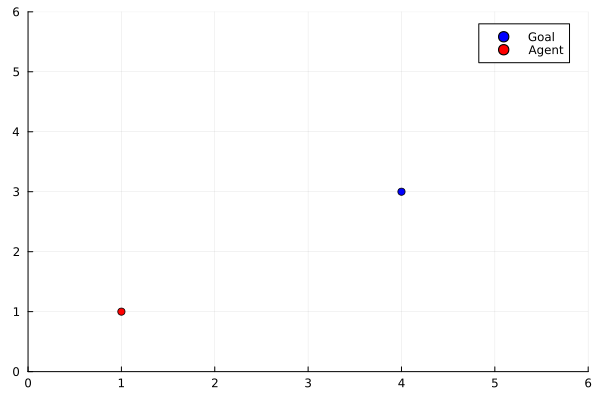

In [21]:
env = RxEnvironment(WindyGridWorld((0, 1, 1, 1, 0), [], (4, 3)))
agent = add!(env, WindyGridWorldAgent((1, 1)))
plot_environment(env)

## Model Setup

First, we'll define our POMDP model structure. We will use the `DiscreteTransition` node in `RxInfer` to define the state transition model. The `DiscreteTransition` node is a special node that accepts any number of `Categorical` distributions as input, and outputs a `Categorical` distribution. This means that we can use it to define a state transition model that accepts the previous state and the control as `Categorical` random variables, but we can also use it to define our observation model! Furthermore, the `DiscreteTransition` node can be used both for parameter inference and for inference-as-planning, isn't that neat?

In [22]:
@model function pomdp_model(p_A, p_B, p_goal, p_control, previous_control, p_previous_state, current_y, future_y, T, m_A, m_B)
    # Instantiate all model parameters with priors
    A ~ p_A
    B ~ p_B
    previous_state ~ p_previous_state
    
    # Paremeter inference
    current_state ~ DiscreteTransition(previous_state, B, previous_control)
    current_y ~ DiscreteTransition(current_state, A)

    prev_state = current_state
    # Inference-as-planning
    for t in 1:T
        controls[t] ~ p_control
        s[t] ~ DiscreteTransition(prev_state, m_B, controls[t])
        future_y[t] ~ DiscreteTransition(s[t], m_A)
        prev_state = s[t]
    end
    # Goal prior initialization
    s[end] ~ p_goal
end

Now, this model, because we use `A` and `B` for every timestep, contains loops, so we have to initialize the inference procedure properly. Furthermore, `RxInfer` does not support learning a joint probability distribution over the parameters and the states, so we have to supply the model with variational constraints that reflect this:

In [23]:
init = @initialization begin
    q(A) = DirichletCollection(diageye(25) .+ 0.1)
    q(B) = DirichletCollection(ones(25, 25, 4))
end

constraints = @constraints begin
    q(previous_state, previous_control, current_state, B) = q(previous_state, previous_control, current_state)q(B)
    q(current_state, current_y, A) = q(current_state, current_y)q(A)
    q(current_state, s, controls, B) = q(current_state, s, controls), q(B)
    q(s, future_y, A) = q(s, future_y), q(A)
end

Constraints: 
  q(previous_state, previous_control, current_state, B) = q(previous_state, previous_control, current_state)q(B)
  q(current_state, current_y, A) = q(current_state, current_y)q(A)
  q(current_state, s, controls, B) = q(current_state, s, controls)q(B)
  q(s, future_y, A) = q(s, future_y)q(A)


Now, in order to use this model, we have to define the priors for the model parameters. The WindyGridworld environment has a 5-by-5 grid, so we need to instantiate a prior 25-by-25 transition matrices for every control! That's quite a lot of parameters, but as we will see, `RxInfer` will handle this just fine. We will give our agent a control space of 4 actions, so we need to instantiate 4 transition matrices. Furthermore, we have to transform the output from the environment to a 1-in-25 index, and the controls from a 1-in-4 index to a direction tuple.

The prior on our observation model tells our model that the prior belief is to trust it's observations, but we might be able to deviate from this. However, in this example, the observation model is deterministic and has no noise, meaning that our agent won't have any reason to deviate from the prior.

In [24]:
p_A = DirichletCollection(diageye(25) .+ 0.1)
p_B = DirichletCollection(ones(25, 25, 4))

function grid_location_to_index(pos::Tuple{Int, Int})
    return (pos[2] - 1) * 5 + pos[1]
end

function index_to_grid_location(index::Int)
    return (index % 5, index ÷ 5 + 1,)
end

function index_to_one_hot(index::Int)
    return [i == index ? 1.0 : 0.0 for i in 1:25]
end

goal = Categorical(index_to_one_hot(grid_location_to_index((4, 3))))


Categorical{Float64, Vector{Float64}}(
support: Base.OneTo(25)
p: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
)


`RxEnvironments.jl` is a package that allows us to easily communicate between our agent and our environment. We can send actions to the environment, and the environment will automatically respond with the corresponding observations. In order to access these in our model, we can subscribe to the observations and then use the `data` function to access the last observation.

Now for our main control loop, we will use a receding horizon control strategy. We will first take an action, observe the environment, and then update our belief. We will then repeat this process for a horizon of 10 steps. In order to learn the parameters of our model, we will conduct this experiment 100 times. We can use the `infer` function from `RxInfer` to perform inference on our model.

In [25]:
# Number of times to run the experiment
n_experiments = 100
# Number of steps in each experiment
T = 4
observations = keep(Any)
# Subscribe the agent to receive observations
RxEnvironments.subscribe_to_observations!(agent, observations)
successes = []


@showprogress for i in 1:n_experiments
    # Reset environment to initial state and initialize state belief to starting position (1,1)
    reset_env!(env)
    p_s = Categorical(index_to_one_hot(grid_location_to_index((1, 1))))
    # Initialize previous action as "down", as this is neutral from the starting position
    policy = [Categorical([0.0, 0.0, 1.0, 0.0])]
    prev_u = [0.0, 0.0, 1.0, 0.0]
    # Run for T-1 steps in each experiment
    for t in 1:T

         # Convert policy to actual movement in environment
         current_action = mode(first(policy))
         if current_action == 1
             send!(env, agent, (0, 1))  # Move up 
             prev_u = [1.0, 0.0, 0.0, 0.0]
         elseif current_action == 2
             send!(env, agent, (1, 0))  # Move right
             prev_u = [0.0, 1.0, 0.0, 0.0]
         elseif current_action == 3
             send!(env, agent, (0, -1))  # Move down
             prev_u = [0.0, 0.0, 1.0, 0.0]
         elseif current_action == 4
             send!(env, agent, (-1, 0))  # Move left
             prev_u = [0.0, 0.0, 0.0, 1.0]
         end

        # Get last observation and convert to one-hot encoding
        last_observation = index_to_one_hot(grid_location_to_index(RxEnvironments.data(last(observations))))
        
        # Perform inference using the POMDP model
        inference_result = infer(
            model = pomdp_model(
                p_A = p_A,  # prior on observation model parameters
                p_B = p_B,  # prior on transition model parameters
                T = max(T - t, 1),  # remaining time steps
                p_previous_state = p_s,  # posterior belief on previous state
                p_goal = goal,  # prior on goal state
                p_control = vague(Categorical, 4),  # prior over controls
                m_A = mean(p_A),
                m_B = mean(p_B)
            ),
            # Provide data for inference
            data = (
                previous_control = prev_u,
                current_y = last_observation,
                future_y = UnfactorizedData(fill(missing, max(T - t, 1)))
            ),
            constraints = constraints,
            initialization = init,
            iterations = 10
        )
        
        # Update beliefs based on inference results
        p_s = last(inference_result.posteriors[:current_state])  # Update state belief
        policy = last(inference_result.posteriors[:controls])  # Get policy

        # Update model parameters globally for the entire notebook
        global p_A = last(inference_result.posteriors[:A])  # Update observation model
        global p_B = last(inference_result.posteriors[:B])  # Update transition model

        if RxEnvironments.data(last(observations)) == (4, 3)
            break
        end
    end
    if RxEnvironments.data(last(observations)) == (4, 3)
        push!(successes, true)
    else
        push!(successes, false)
    end
end



Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


Now, in this example, we have used a trick: we supplied the mean of `p_A` and `p_B` to the model to do the predictions for the future in order to learn the controls. The real reason we did this is because we do not want messages from the future to influence the model parameters, instead only learning the model parameters from past data. This is a simple way to do this, but it is not the only way. We could have supplied the full distribution `p_A` and `p_B` to the model, and used `A` and `B` in the predictive step as well, but then we would need a separate way to make sure we do not use future messages to influence the model parameters.

In [26]:
mean(successes)

0.85

We see that our agent is able to learn the optimal policy for this environment, and reaches the goal state in 85% of cases!

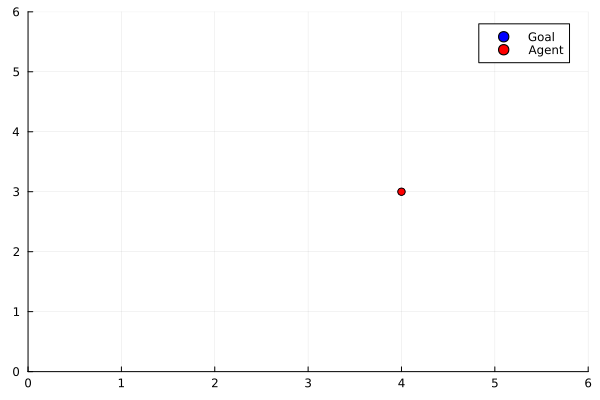

In [27]:
plot_environment(env)